# 2nd order LC ladder
The goal is to factor a 2-stage LC filter polynomial to figure out the resonance points and contributions from each of the passive components to the filter behaviour.
Given:
- L1, C1: the first capacitor and inductor.
- L2, C2: the second capacitor and inductor.

<div>
<img src="images/buck_filter_simple.png" width="800"/>
</div>

Which is equivalent to
<div>
<img src="images/buck_filter_simple_redrawn.png" width="600"/>
</div>


## Impedance calculation
The total impedance: Z_tot = $(Ri + Zl1 + (Zc1 || (Zl2 + (Zc2 || Ro)))$ \
Using Thevenin we calculate
* $Zth = Ri + (Zl1 || Zc1)$ (Vsource short-circuited)
* $Vth = V1.(Zc1) / (Zc1 + Zl1+Ri)$ (Open-circuit voltage) \
Using a voltage divider over Zc2 and Zl2 as well as the thevenin circuit we calculate the transfer function: 
* $Vref = Vth.(Zc2||Ro) / (Zth + Zl2 + (Zc2||Ro))$

In [1]:
import sympy as sp
butterworth = True

In [2]:
C2, L2, C1, L1 = sp.symbols('C2 L2 C1 L1', real=True)
if butterworth:
    Ri, Ro = sp.symbols('Ri Ro', real=True)
else:
    del Ri
    del Ro
    
s = sp.symbols('s', complex=True)
Zc2 = 1/(s*C2)
Zl2 = s*L2
Zc1 = 1/(s*C1)
Zl1 = s*L1

if butterworth:
    Zth = sp.simplify((1/(Zl1+Ri)+ 1/(Zc1))**(-1))
    Vth = sp.simplify(Zc1 / (Zc1+Zl1+Ri))
    Zo = (1/(Zc2) + 1/Ro)**(-1)

else:
    Zth = sp.simplify((1/(Zl1)+ 1/(Zc1))**(-1))
    Vth = sp.simplify(Zc1 / (Zc1+Zl1))
    Zo = Zc2
    
H = sp.simplify(sp.expand((Zo / (Zo + s*L2 + Zth)) * (Vth)))

print(f"Zth = {Zth}")
print(f"Vth = {Vth}")
print(f"H = {H}")

Zth = (L1*s + Ri)/(C1*s*(L1*s + Ri) + 1)
Vth = 1/(C1*s*(L1*s + Ri) + 1)
H = Ro/(C1*C2*L1*L2*Ro*s**4 + C1*C2*L2*Ri*Ro*s**3 + C1*L1*L2*s**3 + C1*L1*Ro*s**2 + C1*L2*Ri*s**2 + C1*Ri*Ro*s + C2*L1*Ro*s**2 + C2*L2*Ro*s**2 + C2*Ri*Ro*s + L1*s + L2*s + Ri + Ro)


**sources**
> https://electronics.stackexchange.com/questions/534192/calculating-transfer-function-for-complicated-circuit

## Butterworth example

Quick sanity check: Fill in values for 4th order butterworth filter and check transfer function

<div>
<img src="images/buck_filter_butterworth.png" width="800"/>
</div>

Quick sanity check: Fill in values for 4th order butterworth filter and check transfer function
<div>
<img src="images/buck_filter_butterworth.png" width="800"/>
</div>

In [16]:
#### DETERMINE THE POLES IN FUNCTION OF C1, C2, L1, L2, Ri, Ro
H_inv = 1/H.subs({Ro:1, Ri:0})
print(f"H_inv = {H_inv}")
poles = sp.solveset(H_inv, s)
H_inv = 1/H.subs({Ro:1, Ri:1})
print(f"H_inv = {H_inv}")
poles = sp.solveset(H_inv, s)

H_inv = C1*C2*L1*L2*s**4 + C1*L1*L2*s**3 + C1*L1*s**2 + C2*L1*s**2 + C2*L2*s**2 + L1*s + L2*s + 1
H_inv = C1*C2*L1*L2*s**4 + C1*C2*L2*s**3 + C1*L1*L2*s**3 + C1*L1*s**2 + C1*L2*s**2 + C1*s + C2*L1*s**2 + C2*L2*s**2 + C2*s + L1*s + L2*s + 2


1/(2.00026180106945e-16*s**4 + 5.226709697072e-12*s**3 + 6.82881424e-8*s**2 + 0.00052264*s + 2)


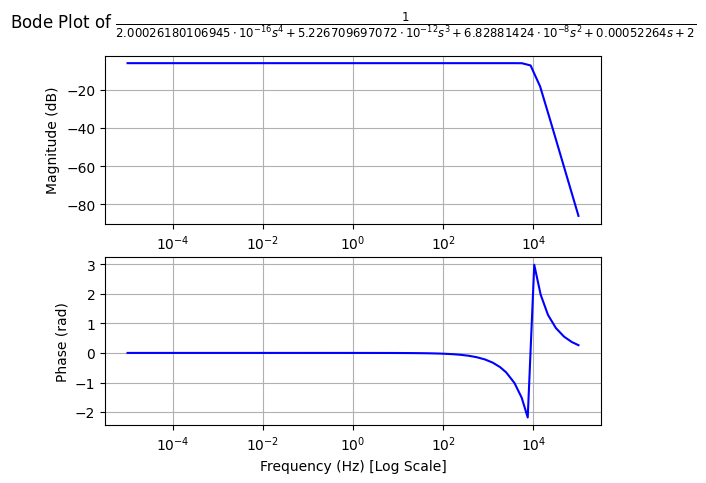

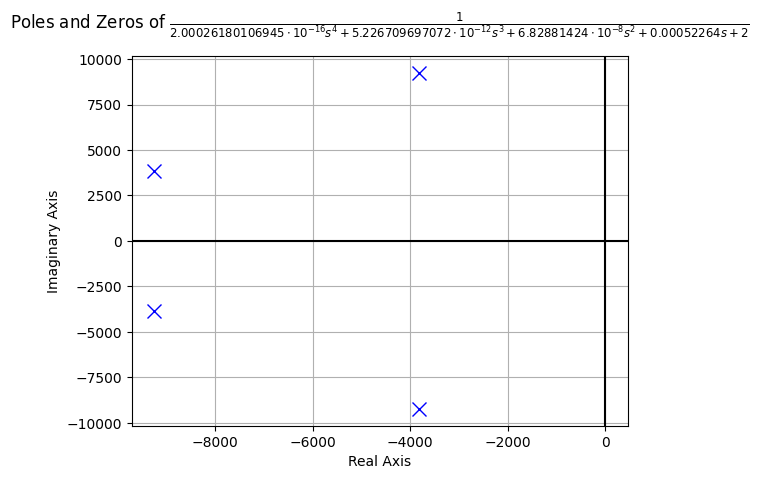

In [17]:
from sympy.physics.control.lti import TransferFunction as TF
from sympy.physics.control import bode_plot, pole_zero_plot

frequency = 1e4
R_factor = 1
factor = 1/frequency
butter_dict = {"L1":0.7654, "C2": 1.8478, "L3": 1.8478, "C4": 0.7654}
butter_dict = {key:value*factor for key, value in butter_dict.items()}
H_subs = H.subs({Ri: 1, Ro:1})
H_subs = H_subs.subs({C1:butter_dict["C2"], C2:butter_dict["C4"], L1:butter_dict["L1"], L2:butter_dict["L3"]})
print(H_subs)
tf = TF(*H_subs.as_numer_denom(), s)
bode_plot(tf)
pole_zero_plot(tf)

**sources**
> https://electronics.stackexchange.com/questions/483094/effect-of-source-and-load-resistances-on-a-filter \
> https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Electronics/Microwave_and_RF_Design_IV%3A_Modules_%28Steer%29/02%3A_Filters/2.07%3A_Butterworth_and_Chebyshev_Filters


# USB Power Filtering

## Ferrite Beads
Frequency bands.
* Inductive frequency band (lowest)
* Resistive frequency band (middle)
* Capacitive frequency band (high)

Characterised typically by:
* DC resistance Rdc
* Impedance at 100 MHz
* Frequency and magnitude of maximum impedance
* Rated current

<div>
<img src="images/filter_ferrite_bead.png" width="1000"/>
</div>

From the sources, it does not seem a good idea to put extra inductance on the power supply line. It seems better to opt for a capacitor at the input.

**Sources:** 
> https://www.analog.com/en/resources/analog-dialogue/articles/ferrite-beads-demystified.html
> https://resources.altium.com/sites/default/files/2022-05/Guide%20to%20Using%20Ferrite%20Beads%20in%20a%20PCB.pdf

## Filtering Capacitor (single-pole RC)

The maximum input capacitance for USB2.0 is 10 uF (7.2.4.1 Inrush Current Limiting). The device must incorporate inrush current limiting if this can't be respected.\
A USB-power supply can be seen as a low-impedance power source, given it will supply whatever current is needed up to 0.5 Amps at a constant voltage of 5 V, so there is barely any voltage drop with current increase.

<div>
<img src="images/filter_capacitor.png" width="600"/>
</div>

### Load voltage calculation
$Zth = Rs || Zc1$ \
$Vth =  Zc / (Zc + Rs)$ \
$Vl = Vth.RL / (Zth + RL)$

In [174]:
import sympy as sp
import pprint
sp.init_printing()
Resr, C = sp.symbols('Resr C', real=True)
Zsource, Zload, s = sp.symbols('Zsource Zload s')
Zc = Resr + 1/(s*C)
# Zthevenin
Zth = ((1/Zc) + (1/Resr))**(-1)
Vth = Zc / (Zc + Zsource)
H = sp.simplify(Vth*Zload / (Zth+Zload))
H

#### Question: What effect does ESR have on the working of the filter?
* Assume ideal voltage source (input impedance Zscource equal to 0)
* Assuming load of 1kOh, and ESR of 0.1 ohm.

In [180]:
# Ideal situation: The a single pole at f = 1/C, normalized source impedance, esr equal to 0
for i in range(5):
    if i == 0:
        Resr_value = 0
    else:
        Resr_value = 10**(i-4)
    dict_sub = {Resr:Resr_value, Zsource:1}
    H_ESR = sp.simplify(H.subs(dict_sub))
    # Ideal situation: Load impedance is equal to infinity.
    H_ESR = sp.limit(H_ESR, Zload, sp.oo);
    print(f"R_ESR: {Resr_value}")
    print(f"H_IDEAL: {H_ESR}")
    zeroes, poles = sp.fraction(H_ESR)
    print(f"POLES: {sp.solve(poles, s)}")
    print(f"ZEROES: {sp.solve(zeroes, s)}\n\n")

R_ESR: 0
H_IDEAL: 1/(C*s + 1)
POLES: [-1/C]
ZEROES: []


R_ESR: 0.001
H_IDEAL: -1.0*(0.001*C*s + 1)*(0.002*C*s + 1)/((-0.002*C*s - 1.0)*(1.001*C*s + 1))
POLES: [-500.0/C, -0.999000999000999/C]
ZEROES: [-1000.0/C, -500.0/C]


R_ESR: 0.01
H_IDEAL: -1.0*(0.01*C*s + 1)*(0.02*C*s + 1)/((-0.02*C*s - 1.0)*(1.01*C*s + 1))
POLES: [-50.0/C, -0.99009900990099/C]
ZEROES: [-100.0/C, -50.0/C]


R_ESR: 0.1
H_IDEAL: -1.0*(0.1*C*s + 1)*(0.2*C*s + 1)/((-0.2*C*s - 1.0)*(1.1*C*s + 1))
POLES: [-5.0/C, -0.909090909090909/C]
ZEROES: [-10.0/C, -5.0/C]


R_ESR: 1
H_IDEAL: -(C*s + 1)/(-2*C*s - 1)
POLES: [-1/(2*C)]
ZEROES: [-1/C]




#### Conclusion
The ESR adds an extra zero in the denominator, which helps stability. For filtering capacitors the ESR should be as low as possible, especially at higher frequency. This limits power loss and increases 
ESR and ESL behaviour of the capacitor (inductance) changing with frequency should be taken into account.

Add a 1 uF capacitor on the power line for 
* Filtering (1/1e-6) -> 1 MHz
* Coulomb-bucket

**Sources:**
> https://www.usb.org/document-library/usb-20-specification \
> https://www.st.com/resource/en/datasheet/ld1117.pdf \
> https://electronics.stackexchange.com/questions/447964/what-is-an-esr-zero-in-a-power-converters-output-filter \
> https://electronics.stackexchange.com/questions/109385/when-should-i-use-a-low-esr-capacitor/109387#109387 \
> Ferrite simulations in "simulations"-folder

# Button Debouncing

<div>
<img src="images/filters_stm32_boot_options.png" width="400"/>
</div>

#### Problem
Due to
* inductance on the power supply line.
* Local differences in ground / power input voltage.
* Multiple accidental presses on the button.

#### Goal
The goal is to design a debouncing circuit which prevents the GPIO input from being in an undefined state:
* When the button is pressed, the boot0 pin is pulled to Vcc.
* By default, the boot0 pin is pulled to ground.

#### Pin Characteristics
* Maximum IO-input sinking current: 25 mA
* Maximum sum of all IO input currents sunk: 80 mA
* Typical GPIO input capacitance: 5 pF

Assume the input pin is a 1 MOhm resistance with a 10 pF input capacitance in parallel.

### Circuit
<div>
<img src="images/filters_gpio_input.png" width="150"/>
</div>


<div>
<img src="images/filters_debouncing_circuit.png" width="400"/>
</div>

Conventions:
* All currents are from GPIO_IN to ground
* All voltages are seen from GPIO_IN to ground

Goal:
* find Vout as a function of time and symbols defined

In [6]:
import sympy as sp
R1, C2, R3, t, t1, t2, C1, R2 = sp.symbols('R1 C2 R3 t t1, t2, C1, R2', real=True)

#### SWITCH_OUT open
* switch_out open
* capacitor C2 discharged over resistors

In [7]:
v_o, ic1_o, ir2_o, ir3_o, ic2_o = sp.symbols('v_o ic1_o ir2_o ir3_o ic2_o', cls=sp.Function)
t0 = 0
bound_cond_o = {v_o(t1): 3.3, ic1_o(t1):0, ic2_o(t1):0, ir2_o(t1):0, ir3_o(t1):0}

In [8]:
eqs_o_list = []

eqs_o_list.append(ic2_o(t) - C2*v_o(t).diff(t))
eqs_o_list.append(ic1_o(t) - C1*v_o(t).diff(t))
eqs_o_list.append(v_o(t) - ir3_o(t)*R3)
eqs_o_list.append(v_o(t) - ir2_o(t)*R2)
eqs_o_list.append(ic1_o(t) + ir2_o(t)+ir3_o(t)+ic2_o(t))

eqs_o = sp.dsolve(eqs_o_list, [v_o(t), ic1_o(t), ir2_o(t), ir3_o(t), ic2_o(t)], ics=bound_cond_o)

In [9]:
v_o_t_function = eqs_o[0]
v_o_t_function

Eq(v_o(t), 3.3*exp(-t*(R2 + R3)/(R2*R3*(C1 + C2)))*exp(t1*(R2 + R3)/(R2*R3*(C1 + C2))))

#### SWITCH_OUT closed
* switch_out closed
* capacitors charged to Vcc

In [18]:
import sympy as sp
R1, C2, R3, t, C1, R2 = sp.symbols('R1 C2 R3 t C1 R2', real=True, positive=True)

### Equations
* $ic2 = C2*dvc2/dt$ 
* $ic1 = C1*dvc2/dt$ 
* $ir2 = vc2 / R2$  
* $ir3 = vc2 / R3$
* $Vcc = ir1*R1 + vc2$ <=> $ir1 = (Vcc-vc2) / R1$ (ir1 convention away from vc2) \
Kirchoff:
* $ic2+ic1+ir2+ir3-ir1=0$ \
Put together:
* $C2*dvc2/dt + C1*dvc2/dt + vc2/R2 + vc2/R3 - (Vcc - vc2)/R1 = 0$ 
* Reworked: $(C2+C1)*dvc2(t)/dt + (1/R2+ 1/R3 + 1/R1)*vc2(t) - Vcc/R1 = 0$

In [30]:
vc2 = sp.symbols('vc2', cls=sp.Function)
Vcc = 3.3 # sp.exp(-10197*t)*sp.sin(t*2*sp.pi/1e-4) * 3.3
t1 = 0
bound_cond_1 = {vc2(t1):0}
functions_1 = [vc2(t)]
subs_dict = {R2:1e6, C1:5e-12, R3:40e3, C2:1e-6, R1:1.5e3}

In [31]:
eq = sp.Eq(-Vcc/R1 + (C1+C2)*vc2(t).diff(t) + (1/R2 + 1/R3 + 1/R1)*vc2(t), 0)
eq

Eq((C1 + C2)*Derivative(vc2(t), t) + (1/R3 + 1/R2 + 1/R1)*vc2(t) - 3.3/R1, 0)

In [32]:
gpio_voltage = sp.dsolve(eq, vc2(t), ics=bound_cond_1, dict=True)
gpio_voltage

Eq(vc2(t), 33.0*R2*R3/(10.0*R1*R2 + 10.0*R1*R3 + 10.0*R2*R3) - 33.0*R2*R3*exp(-t*(1/R3 + 1/R2 + 1/R1)/(C1 + C2))/(10.0*R1*R2 + 10.0*R1*R3 + 10.0*R2*R3))

In [33]:
current_vdd, current_input, ic1, ic2, ir2, ir3 = sp.symbols('current_vdd current_input ic1 ic2 ir2 ir3', cls=sp.Function)

### Calculate the maximum currents (gpio_in and vdd)

In [34]:
ic1 = gpio_voltage.rhs.diff(t) * C1
ic2 = gpio_voltage.rhs.diff(t) * C2
ir2 = gpio_voltage.rhs / R2
ir3 = gpio_voltage.rhs / R3

In [35]:
voltage_gpio = gpio_voltage.rhs.subs(subs_dict)
current_vdd = sp.simplify(ic1+ic2+ir2+ir3).subs(subs_dict)
current_input = sp.simplify(ic1+ir2).subs(subs_dict)

In [38]:
print(f"MAX VDD current: {current_vdd.subs({t:0})}")
print(f"MAX GPIO input current: {current_input.subs({t:0})}")
print(f"INIT GPIO voltage: {voltage_gpio.subs({t:0.01})}")

MAX VDD current: 0.00220000000000000
MAX GPIO input current: 1.09999450002749E-8
INIT GPIO voltage: 3.17301415690518


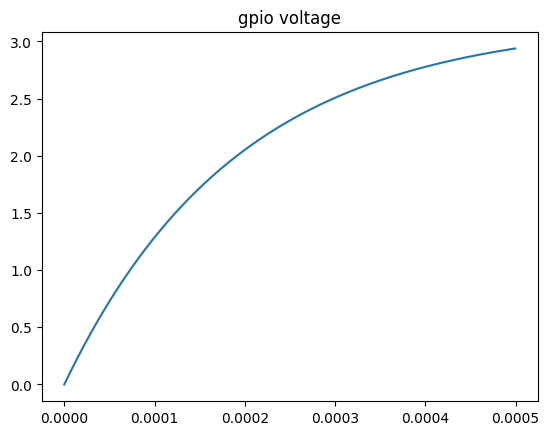

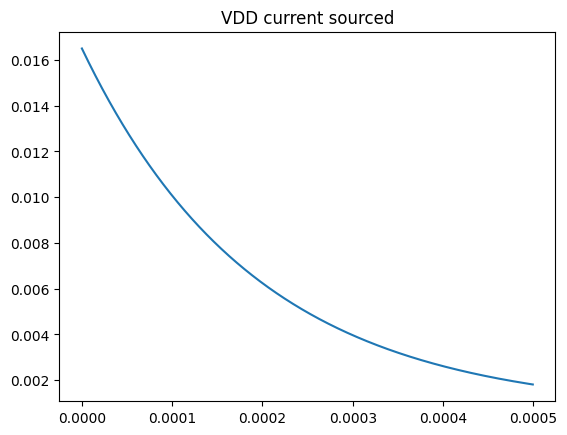

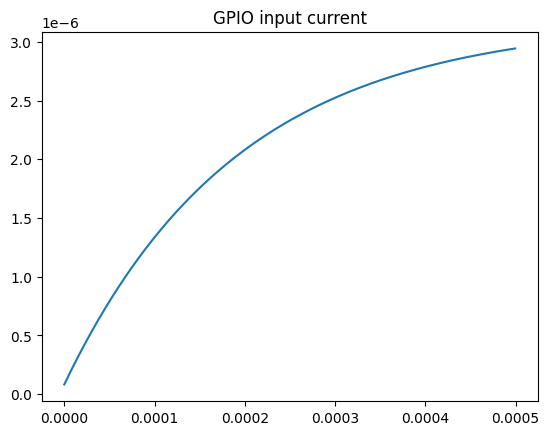

In [29]:
import matplotlib.pyplot as plt

def plot_values(f_sympy, time=5e-4, n_points=1000):
    total_t = []
    total_y = []
    
    for i in range(n_points):
        total_y.append(float(f_sympy.subs({t:float(i*time)/float(n_points)})))
        total_t.append(i*time/float(n_points))
    return total_t, total_y
total_t, total_y = plot_values(voltage_gpio)

plt.plot(total_t, total_y)
plt.title("gpio voltage")
plt.show()
total_t, total_y = plot_values(current_vdd)
plt.plot(total_t, total_y)
plt.title("VDD current sourced")
plt.show()
total_t, total_y = plot_values(current_input)
plt.plot(total_t, total_y)
plt.title("GPIO input current")
plt.show()

#### Effect of noise on line

In [696]:
vc2 = sp.symbols('vc2', cls=sp.Function)
Vcc = sp.exp(-10197*t)*sp.sin(t*2*sp.pi/1e-4) * 3.3
t1 = 0
bound_cond_1 = {vc2(t1):0}
functions_1 = [vc2(t)]
subs_dict = {R2:1e6, C1:5e-12, R3:5.1e3, C2:1e-6, R1:100}

In [ ]:
eq = sp.Eq(-Vcc/R1 + (C1+C2)*vc2(t).diff(t) + (1/R2 + 1/R3 + 1/R1)*vc2(t), 0).subs(subs_dict)
gpio_voltage = sp.dsolve(eq, vc2(t), hint='factorable', ics=bound_cond_1, dict=True)
gpio_voltage

#### Without debouncing
<div>
<img src="images/filters_no_debounce.png" width="600"/>
</div>

#### With debouncing
<div>
<img src="images/filters_debounced.png" width="600"/>
</div>
We choose the values of 1.5kOhm for R1, 40 kOhm for R3, 0.1 uF for C2, given that we used these values in our schematic before and they limit the Vdd current enough + they provide a large enough time constant RC.

***Sources:***
> https://www.allaboutcircuits.com/technical-articles/how-to-reduce-ground-bounce-mitigating-noise-pcb-design-best-practices/

# General sources for filter design
> https://www.analog.com/media/en/training-seminars/design-handbooks/Basic-Linear-Design/Chapter8.pdf?doc=ADA4661-2.pdf \
> https://www.ti.com/lit/an/slvae26a/slvae26a.pdf?ts=1718030068298&ref_url=https%253A%252F%252Fwww.google.com%252F